<a href="https://colab.research.google.com/github/vignesh628/Mask_detection/blob/master/Roboflow_TFLite_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [1]:
cd /content/drive/MyDrive/Experiment

/content/drive/MyDrive/Experiment


In [2]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 100000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    },    
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [3]:
# use TF 1.x for Object Detection APIs as they are not ported to TF 2.0 yet
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
repo_url

'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

## Clone the `tensorflow-object-detection` repository or your fork.

In [5]:
import os

%cd /content/drive/MyDrive/Experiment/

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content/drive/MyDrive/Experiment
fatal: destination path 'tensorflow-object-detection-faster-rcnn' already exists and is not an empty directory.
/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [7]:
%cd /content/drive/MyDrive/Experiment/
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/drive/MyDrive/Experiment/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/drive/MyDrive/Experiment/models/research/:/content/drive/MyDrive/Experiment/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content/drive/MyDrive/Experiment
fatal: destination path 'models' already exists and is not an empty directory.
/content/drive/MyDrive/Experiment/models/research


## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [8]:
%cd /content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data

/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data


In [48]:
import shutil
shutil.copy('/content/drive/MyDrive/train.record','/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/train/')
shutil.copy('/content/drive/MyDrive/valid.record','/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/test/')


'/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/test/valid.record'

In [ ]:
!cp -r /content/train/train/ /content/tensorflow-object-detection-faster-rcnn/data/
!cp -r /content/train/test/ /content/tensorflow-object-detection-faster-rcnn/data/

In [24]:
# training set
%ls train

In [25]:
# test set
%ls test

valid.record


In [26]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/test/valid.record'
train_record_fname = '/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/train/train.record'
label_map_pbtxt_fname = '/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/label_map.pbtxt'

## Download base model

In [27]:
%cd /content/drive/MyDrive/Experiment/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/drive/MyDrive/Experiment/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/drive/MyDrive/Experiment/models/research


In [28]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/drive/MyDrive/Experiment/models/research/pretrained_model
total 135M
-rw------- 1 root root   77 Mar 30  2018 checkpoint
-rw------- 1 root root  67M Mar 30  2018 frozen_inference_graph.pb
-rw------- 1 root root  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw------- 1 root root  15K Mar 30  2018 model.ckpt.index
-rw------- 1 root root 3.4M Mar 30  2018 model.ckpt.meta
-rw------- 1 root root 4.2K Mar 30  2018 pipeline.config
drwx------ 3 root root 4.0K Mar 30  2018 saved_model


In [29]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/drive/MyDrive/Experiment/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [30]:
import os
pipeline_fname = os.path.join('/content/drive/MyDrive/Experiment/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [31]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [32]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [33]:
pipeline_fname

'/content/drive/MyDrive/Experiment/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config'

In [34]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 2
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.05
        max_scale: 1.4
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [35]:
pwd

'/content/drive/MyDrive/Experiment/models/research'

In [36]:
model_dir = 'train/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [37]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-11-17 21:14:15--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.193.208.150, 52.54.205.131, 3.209.148.13, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.193.208.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.9’

ngrok-stable-linux- 100%[===================>]  13.13M  49.6MB/s    in 0.3s    

2020-11-17 21:14:15 (49.6 MB/s) - ‘ngrok-stable-linux-amd64.zip.9’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [38]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [39]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [40]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://633d2e496830.ngrok.io


In [41]:
pip install lvis

## Train the model

In [42]:
model_dir

'train/'

In [44]:
num_steps = 60000

In [46]:
num_eval_steps

50

In [45]:
pwd

'/content/drive/MyDrive/Experiment/models/research'

In [49]:
!python /content/drive/MyDrive/Experiment/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Streaming output truncated to the last 5000 lines.
INFO:tensorflow:loss = 4.592619, step = 9500 (34.501 sec)
I1117 22:20:38.723622 139670126851968 basic_session_run_hooks.py:260] loss = 4.592619, step = 9500 (34.501 sec)
INFO:tensorflow:global_step/sec: 2.81129
I1117 22:21:14.293323 139670126851968 basic_session_run_hooks.py:692] global_step/sec: 2.81129
INFO:tensorflow:loss = 4.6016803, step = 9600 (35.571 sec)
I1117 22:21:14.295135 139670126851968 basic_session_run_hooks.py:260] loss = 4.6016803, step = 9600 (35.571 sec)
INFO:tensorflow:global_step/sec: 2.82319
I1117 22:21:49.714248 139670126851968 basic_session_run_hooks.py:692] global_step/sec: 2.82319
INFO:tensorflow:loss = 4.972662, step = 9700 (35.420 sec)
I1117 22:21:49.715450 139670126851968 basic_session_run_hooks.py:260] loss = 4.972662, step = 9700 (35.420 sec)
2020-11-17 22:21:58.450917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: Not recognizing known sRGB profile that has been edited
INFO:tensorflow:global

In [50]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1605647899.d58cbdec9761
export
graph.pbtxt
model.ckpt-54374.data-00000-of-00001
model.ckpt-54374.index
model.ckpt-54374.meta
model.ckpt-55943.data-00000-of-00001
model.ckpt-55943.index
model.ckpt-55943.meta
model.ckpt-57563.data-00000-of-00001
model.ckpt-57563.index
model.ckpt-57563.meta
model.ckpt-59208.data-00000-of-00001
model.ckpt-59208.index
model.ckpt-59208.meta
model.ckpt-60000.data-00000-of-00001
model.ckpt-60000.index
model.ckpt-60000.meta


## Exporting Trained Inference Graphs
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. We do this again for TFLite. This can be done as follows:

In [51]:
%cd /content/drive/MyDrive/Experiment/models/research

import re
import numpy as np

output_directory = './fine_tuned_model'
tflite_directory = './fine_tuned_model/tflite'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/drive/MyDrive/Experiment/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}
!python /content/drive/MyDrive/Experiment/models/research/object_detection/export_tflite_ssd_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={tflite_directory} \
    --trained_checkpoint_prefix={last_model_path}

/content/drive/MyDrive/Experiment/models/research
train/model.ckpt-60000
Instructions for updating:
Please use `layer.__call__` method instead.
W1118 03:44:49.156479 140150088607616 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1118 03:44:51.185307 140150088607616 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1118 03:44:51.223510 140150088607616 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1118 03:44:51.259675 140150088607616 convolutional_box_predictor.py:156] depth of additional c

In [52]:
output_directory

'./fine_tuned_model'

In [53]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta   tflite
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [54]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
print(pb_fname)
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

/content/drive/MyDrive/Experiment/models/research/fine_tuned_model/frozen_inference_graph.pb


In [ ]:
!ls -alh {pb_fname}

### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
from google.colab import files
files.download(pb_fname)

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
files.download(pipeline_fname)

In [ ]:
!tar cfz fine_tuned_model.tar.gz fine_tuned_model
from google.colab import files
files.download('fine_tuned_model.tar.gz')

## Run inference test
Test with images in repository `tensorflow-object-detection/test` directory.

**To test with your own images, you need to place your images inside the `test` directory in this Colab notebook!** More on this below.

In [ ]:
# !cp -r /content/drive/MyDrive/Experiment/test/test/ /content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/

In [55]:
repo_dir_path

'/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn'

In [56]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
# PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")
PATH_TO_TEST_IMAGES_DIR =  "/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/test_images/"


assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/test_images/1803.jpg', '/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/test_images/1804.jpg', '/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/test_images/1802.jpg', '/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/test_images/1806.jpg', '/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/test_images/1805.jpg', '/content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/data/test_images/1801.jpg']


In [57]:
!ls /content/drive/MyDrive/Experiment/tensorflow-object-detection-faster-rcnn/

data			    requirements.txt
deploy			    resize_images.py
generate_tfrecord.py	    tensorflow_object_detection_training_colab.ipynb
LICENSE			    Tutorial_Faster_RCNN.ipynb
local_inference_test.ipynb  Tutorial_Mobilenet.ipynb
local_inference_test.py     xml_to_csv.py
README.md


In [58]:
%cd /content/drive/MyDrive/Experiment/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/drive/MyDrive/Experiment/models/research/object_detection


In [59]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [60]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

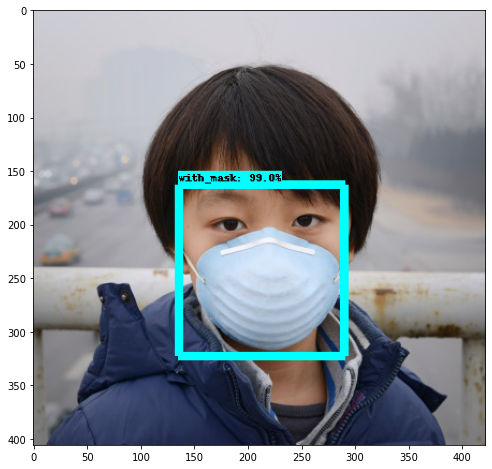

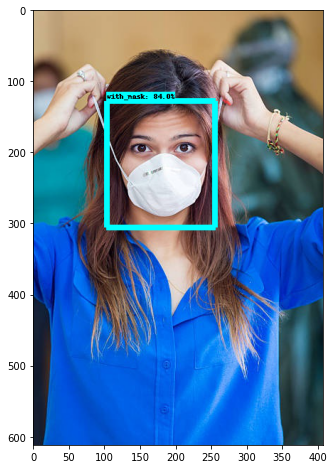

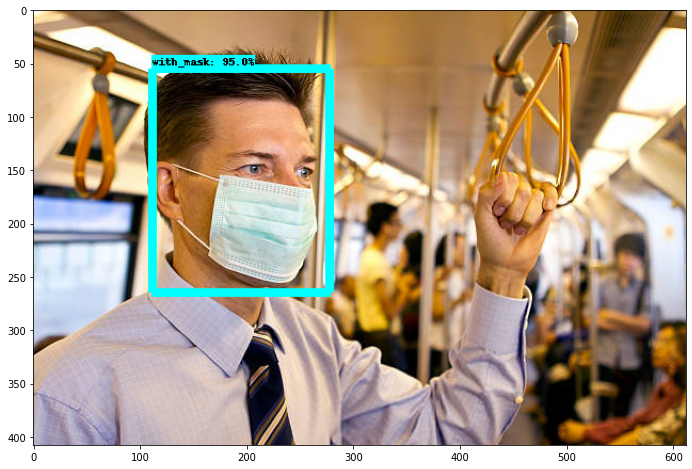

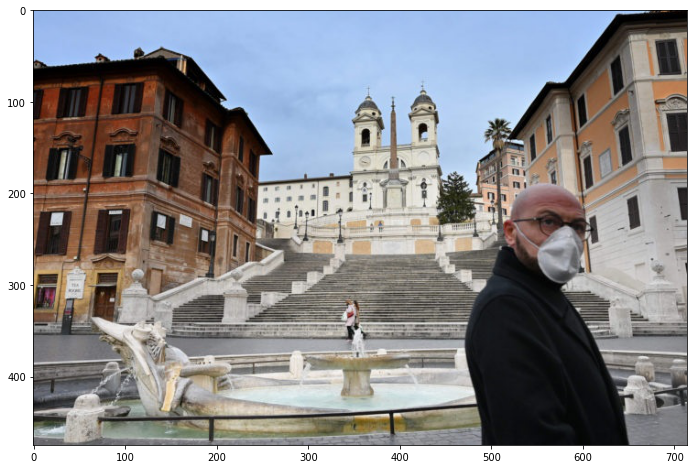

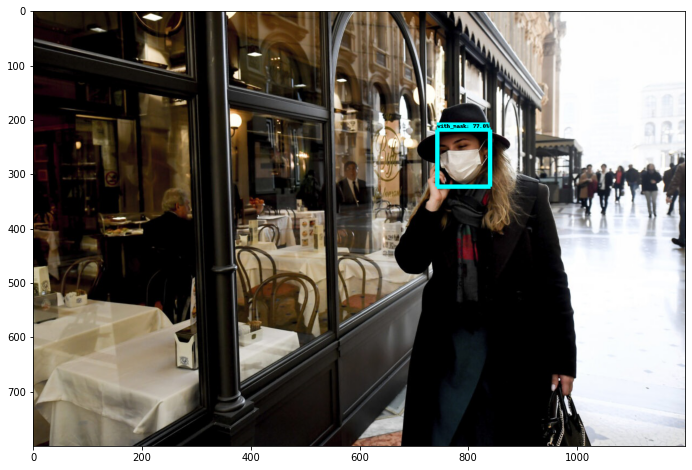

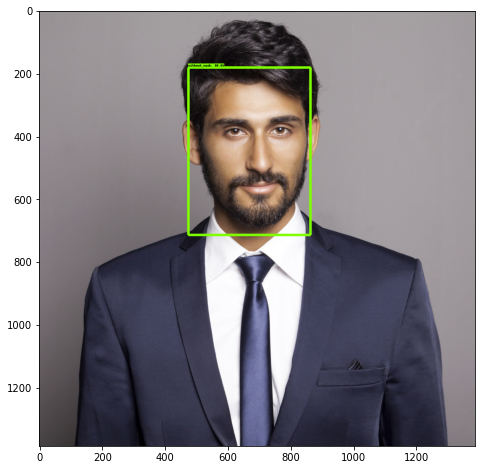

In [61]:
# Limited displayed images to 5 to reduce memory
count = 5
for i, image_path in enumerate(TEST_IMAGE_PATHS):
    if i > count:
        break
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

# 3. Convert

With our model trained, it's time to convert our graph to .tflite!

In [62]:
%ls /content/drive/MyDrive/Experiment/models/research/fine_tuned_model/tflite

tflite_graph.pb  tflite_graph.pbtxt


In [63]:
!tflite_convert \
  --input_shape=1,300,300,3 \
  --input_arrays=normalized_input_image_tensor \
  --output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 \
  --allow_custom_ops \
  --graph_def_file=/content/drive/MyDrive/Experiment/models/research/fine_tuned_model/tflite/tflite_graph.pb \
  --output_file="/content/drive/MyDrive/Experiment/models/research/fine_tuned_model/final_model.tflite"

2020-11-18 03:56:33.821091: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-18 03:56:33.826276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-18 03:56:33.826786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-11-18 03:56:33.827036: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-11-18 03:56:33.829007: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-18 03:56:33.830686: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change the final TFLite destination here
# !cp /content/drive/MyDrive/Experiment/models/research/fine_tuned_model/final_model.tflite "/content/drive/MyDrive/Experiment/drive/My Drive/"

Your TFLite file is now in your Drive as "final_model.tflite", ready to use with your project on-device! For specific device tutorials, check out the official TensorFlow Lite [Android Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), or [Raspberry Pi Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi). [link text](https://)